# Assignment 1
## Numerical Optimization & Large Scale Linear Algebra

### Theofanis Nitsos, p3352325

In [1]:
import numpy as np
import pandas as pd

### Loading data
The data in the text file are the actual prices per stock per day instead of the percentage change in their price. Therefore the data is loaded in a dataframe and converted to percentage change with relation to the previous day. 

Because of this conversion the first row is "lost" since it acts as a reference

In [2]:
# Step 1: Read the data
file_path = 'portfolio_data.txt'
column_names = [
    "American Express Company", "Bank of America Corporation", "BP plc", 
    "Broadcom Corp.", "Costco Wholesale Corporation", "Cisco Systems, Inc.", 
    "The Walt Disney Company", "The Goldman Sachs Group, Inc.", 
    "Hewlett-Packard Company", "Intel Corporation", "The Coca-Cola Company", 
    "3M Company", "Microsoft Corporation", "Nike, Inc.", 
    "QUALCOMM Incorporated", "Starbucks Corporation", "AT&T, Inc.", 
    "Tiffany & Co.", "Verizon Communications Inc.", "US Dollar"
]
data = pd.read_csv(file_path, delim_whitespace=True, header=None, names=column_names)
data2 = data.iloc[21:]
data2 = data2.apply(pd.to_numeric)
fractional_returns = data2.pct_change().dropna()

/var/folders/qf/5rvllq2n4g5_qsf6vgcj00w80000gn/T/ipykernel_51201/767300319.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True, header=None, names=column_names)


In [4]:
fractional_returns.iloc[:2000, :]

,American Express Company,Bank of America Corporation,BP plc,Broadcom Corp.,Costco Wholesale Corporation,"Cisco Systems, Inc.",The Walt Disney Company,"The Goldman Sachs Group, Inc.",Hewlett-Packard Company,Intel Corporation,The Coca-Cola Company,3M Company,Microsoft Corporation,"Nike, Inc.",QUALCOMM Incorporated,Starbucks Corporation,"AT&T, Inc.",Tiffany & Co.,Verizon Communications Inc.,US Dollar
22,0.008662,0.002989,0.010130,0.038196,-0.004639,0.021525,0.019608,0.000461,0.021945,0.023361,0.001067,0.018979,0.024876,-0.000674,0.021203,0.014896,0.034806,-0.005663,0.028754,0.00004
23,0.001662,-0.001656,0.006268,-0.011082,0.011318,0.011414,0.002404,-0.005875,0.004392,-0.000400,-0.004262,-0.003053,0.003398,-0.001349,-0.009746,0.012125,0.002587,0.008137,0.016563,0.00004
24,0.003042,-0.002322,-0.023669,0.000896,0.014483,0.019965,0.016787,0.020973,-0.017493,0.033253,-0.006421,-0.017152,-0.000968,0.003376,0.028241,-0.003783,0.010323,-0.013721,0.002037,0.00004
25,-0.003033,0.000332,0.000957,0.019704,0.004543,0.030638,0.014623,0.001248,0.056874,0.007367,0.004847,-0.006700,-0.001453,0.010094,0.057428,-0.008861,0.018519,-0.024550,0.015244,0.00004
26,-0.007467,-0.008641,0.000319,0.019763,0.019057,0.005367,-0.003719,-0.012696,-0.021058,-0.008083,-0.010718,-0.003451,-0.017944,-0.007328,0.000000,-0.008301,-0.050784,-0.001119,-0.029029,0.00004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017,0.011373,0.026834,0.006509,0.014498,0.005350,0.012754,0.008850,0.026335,0.015818,0.015118,-0.000971,0.014667,0.019182,0.003657,0.002887,0.006605,0.006369,0.004198,0.005384,0.00004
2018,-0.004456,-0.001742,-0.000259,-0.010548,0.009882,-0.002862,-0.002830,0.013505,0.002279,0.013579,0.005507,0.014849,-0.001673,-0.003643,0.006142,-0.010546,0.000791,0.015947,0.006843,0.00004
2019,0.012148,0.019197,-0.012160,0.023728,-0.006649,0.013777,0.007378,0.039258,0.007958,0.012100,0.001611,0.003237,-0.002095,-0.003657,-0.006868,0.003316,0.007905,0.007162,0.000000,0.00004
2020,-0.027374,-0.051370,-0.022263,-0.033927,-0.019576,-0.022084,-0.031831,-0.049610,-0.026316,-0.037148,-0.000965,-0.023490,-0.007976,-0.007340,-0.007107,-0.023135,-0.018431,-0.036465,-0.013298,0.00004


### Training / Test split
The data is split. The first 2000 rows are reserved for training while the rest for test

In [3]:
# Step 1: Load the dataset and split into training and test sets
R_train = fractional_returns.iloc[:2000, :]
R_test = fractional_returns.iloc[2000:, :]

# Define the number of trading days in a year
P = 250

print("R_train: ", R_train.shape)
print("R_test: ", R_test.shape)

R_train:  (2000, 20)
R_test:  (516, 20)


## Constrained Least Squares
We apply constrained least squares to the equation:  $ || R \, w - \rho 1||^2$ provided in the readme file. The constraints as provided are:
- the sum of weights should be 1. Shortselling is allowed, meaning weights can take negative values
- the return of investment ($\rho$) should be the requested one (10%, 20%, 40%)  

Thus, the weights are calculated from the returns of the first 2000 days after applying the constraints. Accordingly the cumulative return and risk are calculated as:
- $P \, avg(r) $
- $ \sqrt{P} std(r) $

It is worth noting that usually the objective function minimised in similar problems has to do with Portfolio Volatility and is defined as
$ \sqrt{w^T \sum w} $


## Portfolio optimisation on the training dataset

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Redefine objective function to use the squared norm difference
def objective_function(w, returns, target):
    return np.linalg.norm(np.dot(returns, w) - target * np.ones(len(returns))) ** 2

def mean_portfolio_return_constraint(w, returns, target):
    T = len(returns)
    mu = (1 / T) * np.dot(returns.T, np.ones((T, 1)))
    return np.dot(mu.T, w) - target

# Define cumulative portfolio value calculation
def cumulative_portfolio_value(weights, returns, initial_investment=10000):
    daily_returns = np.dot(returns, weights)
    cumulative_values = np.cumprod(1 + daily_returns) * initial_investment
    return cumulative_values

# Reporting function
def report_portfolio_performance(weights, returns, P, label):
    avg_daily_return = np.sum(returns.mean() * weights)
    port_return = avg_daily_return * P
    #daily_port_volatility = np.sqrt(np.dot(weights.T, np.dot(returns.cov(), weights)))
    daily_port_volatility = np.std(np.dot(returns, weights))
    port_volatility = daily_port_volatility * np.sqrt(P)
    leverage = np.sum(np.abs(weights))
    min_alloc = np.min(weights)
    max_alloc = np.max(weights)
    
    print(f"{label} Portfolio Performance:")
    print(f"Annualized Return: {port_return * 100:.2f}%")
    print(f"Annualized Risk (Volatility): {port_volatility * 100:.2f}%")
    print(f"Minimum Allocation: {min_alloc:.4f}")
    print(f"Maximum Allocation: {max_alloc:.4f}")
    print(f"Leverage: {leverage:.4f}")
    print()

# Define initial guess for weights
n_assets = len(R_train.columns)
w0 = np.ones(n_assets) / n_assets

# Define target annualized returns
target_annual_returns = [0.1, 0.2, 0.4]
P = 250  # Number of trading days in a year
initial_investment = 10000 # Define initial investment amount

# Optimization loop
results = {}
for target in target_annual_returns:
    daily_target = target / P
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
            {'type': 'eq', 'fun': lambda w: mean_portfolio_return_constraint(w, R_train.values, daily_target)})
    res = minimize(objective_function, w0, args=(R_train.values, daily_target), constraints=cons, method='SLSQP')
    results[target] = res.x

## Questions 1 & 2

In [6]:
# Print results and plot cumulative portfolio values for training set
cumulative_values_train = {}
for target, weights in results.items():
    report_portfolio_performance(weights, R_train, P, f"Training Set (Target Return {target * 100}%)")
    cumulative_values_train[target] = cumulative_portfolio_value(weights, R_train)


Training Set (Target Return 10.0%) Portfolio Performance:
Annualized Return: 10.00%
Annualized Risk (Volatility): 8.65%
Minimum Allocation: -0.1349
Maximum Allocation: 0.7326
Leverage: 1.9617

Training Set (Target Return 20.0%) Portfolio Performance:
Annualized Return: 20.00%
Annualized Risk (Volatility): 18.26%
Minimum Allocation: -0.2848
Maximum Allocation: 0.4356
Leverage: 3.0308

Training Set (Target Return 40.0%) Portfolio Performance:
Annualized Return: 40.00%
Annualized Risk (Volatility): 37.48%
Minimum Allocation: -0.5846
Maximum Allocation: 0.7179
Leverage: 5.4843



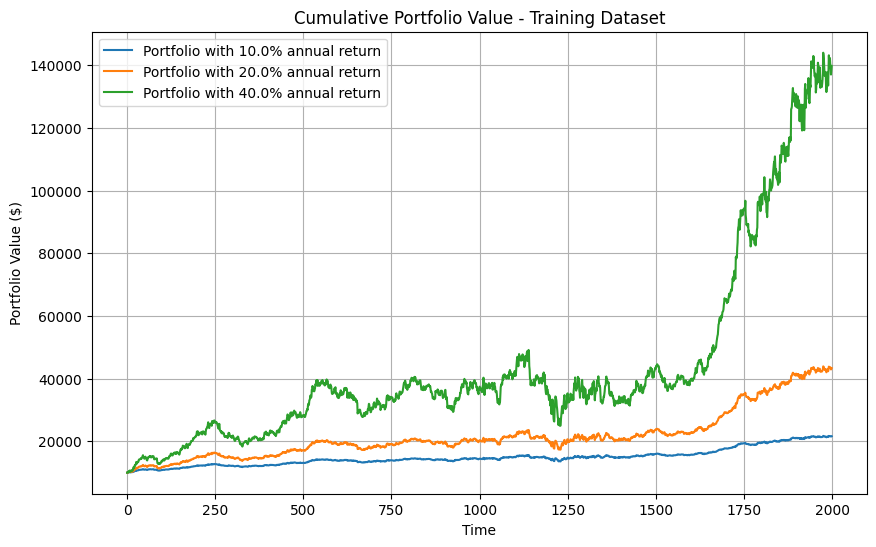

In [7]:
plt.figure(figsize=(10, 6))
for target, values in cumulative_values_train.items():
    plt.plot(values, label=f'Portfolio with {target*100}% annual return')
plt.title('Cumulative Portfolio Value - Training Dataset')
plt.xlabel('Time')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()

### Sanity check on annualised returns

In [8]:
for target in target_annual_returns:
    actual_annual_return = (np.power(((cumulative_values_train[target])[-1]/initial_investment), 1/(R_train.shape[0]/P))-1)
    print(f" Actual Annualized Return for {target*100}%: {actual_annual_return * 100:.2f}%")

 Actual Annualized Return for 10.0%: 10.10%
 Actual Annualized Return for 20.0%: 20.12%
 Actual Annualized Return for 40.0%: 39.06%


### Comments on the training dataset

On the training set the weights chosen through the least squares method achieve the desired return while minimizing risk. As the return increases so does the risk, leverage and amount allocation which is to be expected. To generate higher returns one has to invest in higher return / risk assets, meaning assets that their price fluctuates more.

The plots are almost identical with the readme file indicating that calculations are correct.

## Portfolio optimisation on the test dataset

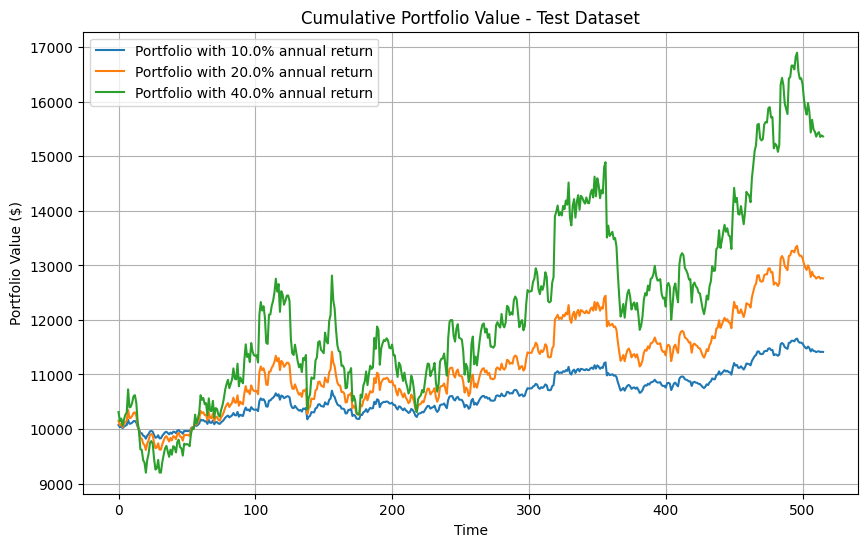

Testing Set (Target Return 10.0%) Portfolio Performance:
Annualized Return: 6.66%
Annualized Risk (Volatility): 7.06%
Minimum Allocation: -0.1349
Maximum Allocation: 0.7326
Leverage: 1.9617

Testing Set (Target Return 20.0%) Portfolio Performance:
Annualized Return: 12.93%
Annualized Risk (Volatility): 14.90%
Minimum Allocation: -0.2848
Maximum Allocation: 0.4356
Leverage: 3.0308

Testing Set (Target Return 40.0%) Portfolio Performance:
Annualized Return: 25.49%
Annualized Risk (Volatility): 30.58%
Minimum Allocation: -0.5846
Maximum Allocation: 0.7179
Leverage: 5.4843



In [9]:
# Calculate cumulative portfolio values for each portfolio in testing set
cumulative_values_test = {}
for target, weights in results.items():
    cumulative_values_test[target] = cumulative_portfolio_value(weights, R_test)

plt.figure(figsize=(10, 6))
for target, values in cumulative_values_test.items():
    plt.plot(values, label=f'Portfolio with {target*100}% annual return')
plt.title('Cumulative Portfolio Value - Test Dataset')
plt.xlabel('Time')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()

# Report testing set performance
for target, weights in results.items():
    report_portfolio_performance(weights, R_test, P, f"Testing Set (Target Return {target * 100}%)")

## Question 3 - Comment on the results

The model performance on the test dataset is different than on the training dataset. That can be attributed to the random nature of the stock prices. Although our model learned from the training data there is no guarantee that the trends apparent in the training dataset will carry on the test data.   

Despite this the model performs fairly well, but fails to achieve the required return in all cases. For all cases it achieves lower returns than the ones requested with lower risk. Therefore in the plots we notice significant increases and decreases of the portfolio value throughout the ~500 days of trading.

# Additional Challenge
Include:
- transaction costs
- liquidity constraints

In the code below both have been implemented and can be configured. It is worth noting that the transaction costs do not influence the result since we consider that the amount is invested once. If the investments changed as the trading periods progressed then it would have a much more profound influence on the result.

In [11]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Load the data
file_path = 'portfolio_data.txt'
column_names = [
    "American Express Company", "Bank of America Corporation", "BP plc", 
    "Broadcom Corp.", "Costco Wholesale Corporation", "Cisco Systems, Inc.", 
    "The Walt Disney Company", "The Goldman Sachs Group, Inc.", 
    "Hewlett-Packard Company", "Intel Corporation", "The Coca-Cola Company", 
    "3M Company", "Microsoft Corporation", "Nike, Inc.", 
    "QUALCOMM Incorporated", "Starbucks Corporation", "AT&T, Inc.", 
    "Tiffany & Co.", "Verizon Communications Inc.", "US Dollar"
]
data = pd.read_csv(file_path, delim_whitespace=True, header=None, names=column_names)
data2 = data.iloc[21:]
data2 = data2.apply(pd.to_numeric)
fractional_returns = data2.pct_change().dropna()

# Set transaction cost and tax parameters
transaction_cost_rate = 0.001  # 0.1% transaction cost
capital_gains_tax_rate = 0.15  # 15% capital gains tax
liquidity_limit = 0.1  # 10% of average volume

# Define a modified portfolio value calculation with transaction costs and taxes
def cumulative_portfolio_value_with_costs(weights, returns, initial_investment=10000, transaction_cost_rate=0.001, capital_gains_tax_rate=0.15):
    daily_returns = np.dot(returns, weights)
    cumulative_values = [initial_investment]
    last_value = initial_investment
    for r in daily_returns:
        transaction_cost = transaction_cost_rate * np.abs(r) * last_value
        capital_gains_tax = capital_gains_tax_rate * max(0, r) * last_value
        net_return = r * last_value - transaction_cost - capital_gains_tax
        last_value += net_return
        cumulative_values.append(last_value)
    return np.array(cumulative_values)

# Modify the objective function to include transaction costs and taxes
def objective_function_with_costs(weights, returns, target, transaction_cost_rate=0.001, capital_gains_tax_rate=0.15):
    T = len(returns)
    mu = (1 / T) * np.dot(returns.T, np.ones((T, 1)))
    cumulative_values = cumulative_portfolio_value_with_costs(weights, returns, initial_investment=10000, transaction_cost_rate=transaction_cost_rate, capital_gains_tax_rate=capital_gains_tax_rate)
    portfolio_return = cumulative_values[-1] / cumulative_values[0] - 1
    return np.sum((np.dot(returns, weights) - target * np.ones(len(returns))) ** 2)

# Define constraints including liquidity constraints
def liquidity_constraint(weights, average_volumes, liquidity_limit=0.1):
    return liquidity_limit - np.sum(weights / average_volumes)

# Average volumes (dummy values, should be replaced with actual data)
average_volumes = np.ones(len(column_names)) * 1e6

# Optimization loop with modified objective function
n_assets = len(R_train.columns)
w0 = np.ones(n_assets) / n_assets
target_annual_returns = [0.1, 0.2, 0.4]
P = 250  # Number of trading days in a year
initial_investment = 10000

results = {}
for target in target_annual_returns:
    daily_target = target / P
    cons = (
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': lambda w: mean_portfolio_return_constraint(w, R_train.values, daily_target)},
        {'type': 'ineq', 'fun': lambda w: liquidity_constraint(w, average_volumes, liquidity_limit)}
    )
    res = minimize(objective_function_with_costs, w0, args=(R_train.values, daily_target, transaction_cost_rate, capital_gains_tax_rate), constraints=cons, method='SLSQP')
    results[target] = res.x

# Reporting function to include new metrics
def report_portfolio_performance_with_costs(weights, returns, P, label):
    cumulative_values = cumulative_portfolio_value_with_costs(weights, returns)
    avg_daily_return = np.sum(returns.mean() * weights)
    port_return = avg_daily_return * P
    daily_port_volatility = np.std(np.dot(returns, weights))
    port_volatility = daily_port_volatility * np.sqrt(P)
    leverage = np.sum(np.abs(weights))
    min_alloc = np.min(weights)
    max_alloc = np.max(weights)
    
    print(f"{label} Portfolio Performance:")
    print(f"Final Portfolio Value: ${cumulative_values[-1]:.2f}")
    print(f"Annualized Return: {port_return * 100:.2f}%")
    print(f"Annualized Risk (Volatility): {port_volatility * 100:.2f}%")
    print(f"Minimum Allocation: {min_alloc:.4f}")
    print(f"Maximum Allocation: {max_alloc:.4f}")
    print(f"Leverage: {leverage:.4f}")
    print()

# Report performance for each target return
for target, weights in results.items():
    report_portfolio_performance_with_costs(weights, fractional_returns.values, P, f"Target Return {target*100}%")


/var/folders/qf/5rvllq2n4g5_qsf6vgcj00w80000gn/T/ipykernel_51201/3931205027.py:16: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True, header=None, names=column_names)


Target Return 10.0% Portfolio Performance:
Final Portfolio Value: $11046.61
Annualized Return: 12.07%
Annualized Risk (Volatility): 8.35%
Minimum Allocation: -0.1349
Maximum Allocation: 0.7326
Leverage: 1.9617

Target Return 20.0% Portfolio Performance:
Final Portfolio Value: $10376.82
Annualized Return: 12.07%
Annualized Risk (Volatility): 17.62%
Minimum Allocation: -0.2848
Maximum Allocation: 0.4356
Leverage: 3.0308

Target Return 40.0% Portfolio Performance:
Final Portfolio Value: $7336.96
Annualized Return: 12.07%
Annualized Risk (Volatility): 36.18%
Minimum Allocation: -0.5846
Maximum Allocation: 0.7179
Leverage: 5.4843



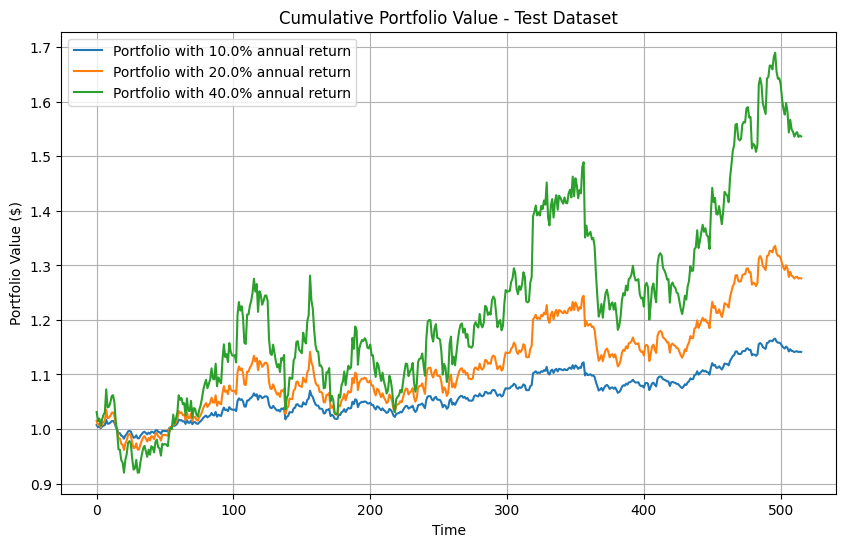

In [15]:
# Calculate cumulative portfolio values for each portfolio in testing set
cumulative_values_test = {}
for target, weights in results.items():
    cumulative_values_test[target] = cumulative_portfolio_value(weights, R_test)

plt.figure(figsize=(10, 6))
for target, values in cumulative_values_test.items():
    plt.plot(values, label=f'Portfolio with {target*100}% annual return')
plt.title('Cumulative Portfolio Value - Test Dataset')
plt.xlabel('Time')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.grid(True)
plt.show()
